# Exercise 8: Tracking

Some code cells will be marked with 
```
##########################
######## To Do ###########
##########################
```

This indicates that you are being asked to write a piece of code to complete the notebook.

In [1]:
import os

import numpy as np

import imageio
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K

## Problem framing

Given robust segmentation models, cell tracking can be framed simply as a problem of connecting objects between frames. To begin examining this problem, we will start by loading a time lapse movie of fluorescent nuclei.

In [2]:
from deepcell.datasets.tracked import hela_s3_bench

(X_train, y_train), (X_test, y_test) = hela_s3_bench.load_tracked_data(seed=0)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

/Users/morganschwartz/opt/anaconda3/envs/mbl/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


X_train shape: (14, 40, 216, 256, 1)
X_test shape: (4, 40, 216, 256, 1)


In [3]:
x = X_train[12]  # chosen batch with divisions

In [6]:
from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video

# Raw
HTML(get_js_video(np.expand_dims(x, axis=0),
                  batch=0, cmap='gray'))

### Initialize nuclear model

The application will download pretrained weights for nuclear segmentation. For more information about application objects, please see our [documentation](https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html).

In [7]:
from deepcell.applications import NuclearSegmentation

app = NuclearSegmentation()

2021-09-28 08:16:36.067644: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Use the application to generate labeled images

Typically, neural networks perform best on test data that is similar to the training data. In the realm of biological imaging, the most common difference between datasets is the resolution of the data measured in microns per pixel. The training resolution of the model can be identified using `app.model_mpp`.

In [8]:
print('Training Resolution:', app.model_mpp, 'microns per pixel')

Training Resolution: 0.65 microns per pixel


The resolution of the input data can be specified in `app.predict` using the `image_mpp` option. The `Application` will rescale the input data to match the training resolution and then rescale to the original size before returning the labeled image.

In [9]:
y_pred = app.predict(x, image_mpp=0.65)

print(y_pred.shape)

2021-09-28 08:16:44.246013: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


(40, 216, 256, 1)


In [10]:
from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video

# Raw
HTML(get_js_video(np.expand_dims(y_pred, axis=0),
                  batch=0))

Now we can see that the nuclear model successfully created a label mask for each cell however if you look closely you can see that the label of each cells changes over time. After tracking the cells, we want the label to be consistent over time.

## Linear assignment approach to cell tracking

Now that we have a set of nuclear objects labeled in each frame, cell tracking can be framed simply as a problem of connecting objects in frame n to objects in frame n+1. However we need to also deal with the possibility that cells can die or divide into new daughter cells. In order to accomodate this complication, we have adapted a linear assignment framework first introduced by Jaqaman et al (2008). The goal of the linear assignment algorithm is to select a set of pairs such that the sum of the selected weights is minimized. In the framework established by Jaqaman et al, the cost matrix is divided into four quadrants. The top left and bottom right corners correspond to direct matches between objects in frame n to objects in frame n+1. The bottom left corner is populated by a diagonal matrix where diagonal values correspond to the probability of a cell dividing. The top right corner is filled with another diagonal matrix in which the diagonal values correspond to the probability of cell death. A diagram of the cost matrix is shown below. 


[Jaqaman et al (2008). Robust single-particle tracking in live-cell time-lapse sequences. Nature methods, 5(8), 695-702.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2747604/)

![Linear Assignment Process](./LAP_Process.jpg)

### Calculate IoU
In order to populate the top left and bottom right corners of the cost matrix, we can begin by using the intersection-over-union of each pair of objects between frame n and frame n+1. This metric gives us a measurement of the overlap between objects. First, write a function to calculate the intersection-over-union between two cells.

In [ ]:
##########################
######## To Do ###########
##########################

def calculate_iou(mask1, mask2):
    """Calculates intersection-over-union between two binary masks
    
    Args:
        mask1 (np.array): Binary array for the mask of one cell
        mask2 (np.array): Binary array for the mask of the second cell
        
    Returns:
        float: IoU value
    """
    
    pass

In [12]:
###### Solution #######

def calculate_iou(mask1, mask2):
    """Calculates intersection-over-union between two binary masks
    
    Args:
        mask1 (np.array): Binary array for the mask of one cell
        mask2 (np.array): Binary array for the mask of the second cell
        
    Returns:
        float: IoU value
    """
    
    intersection = np.count_nonzero(np.logical_and(mask1, mask2))
    union = np.count_nonzero(np.logical_or(mask1, mask2))

    iou = intersection / union
    return iou

### Prepare IoU Matrix
We can now use the function `calculate_iou` as the basis for a function that takes in two frames and calculates the iou value for each possible pair of cells between the two frames.

In [13]:
from skimage.segmentation import relabel_sequential

In [14]:
##########################
######## To Do ###########
##########################

def prepare_iou_matrix(frame1, frame2):
    """Prepares a matrix comparing cells in frame 1 to cells in frame2
    based on the iou of the two cells
    
    Args:
        frame1 (np.array): Labeled array for the first frame with n cells
        frame2 (np.array): Labeled array for the second frame with m cells
        
    Returns:
        np.array: nxm array
    """
    # Relabel both arrays sequentially to make calculations easier
    frame1= relabel_sequential(frame1)[0]
    frame2 = relabel_sequential(frame2)[0]
    
    # Add your code here
    # Remember to skip the background (0) when calculating iou
    
    pass

In [15]:
###### Solution #######

def prepare_iou_matrix(frame1, frame2):
    """Prepares a matrix comparing cells in frame 1 to cells in frame2
    based on the iou of the two cells
    
    Args:
        frame1 (np.array): Labeled array for the first frame with n cells
        frame2 (np.array): Labeled array for the second frame with m cells
        
    Returns:
        np.array: nxm array
    """
    # Relabel both arrays sequentially to make calculations easier
    frame1 = relabel_sequential(frame1)[0]
    frame2 = relabel_sequential(frame2)[0]
    
    num_cells_1 = np.max(frame1)
    num_cells_2 = np.max(frame2)
    
    arr = np.zeros((num_cells_1, num_cells_2))
    
    for i, m in enumerate(range(1, num_cells_1 + 1)):
        for j, n in enumerate(range(1, num_cells_2 + 1)):
            arr[i,j] = calculate_iou(frame1 == m, frame2 == n)
            
    return arr

### Inspect IoU matrix
Let's take a look at the iou matrices for 3 frames, two of which have divisions. In the second and third examples you should see that we cannot directly use this matrix to assign cells in the first frame to the second frame because the parent cell in the first frame significantly overlaps with two daughter cells in the second frame.

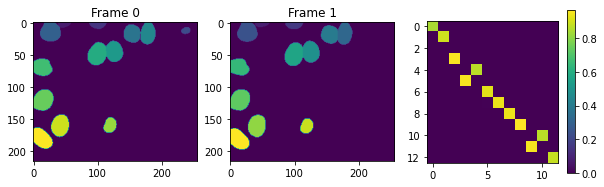

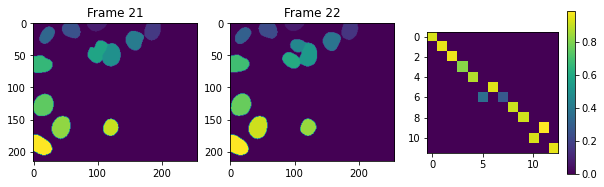

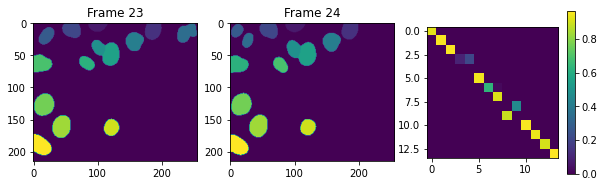

In [16]:
for i in [0, 21, 23]:
    iou = prepare_iou_matrix(y_pred[i], y_pred[i+1])
    fig,ax = plt.subplots(1,3, figsize=(10,10))
    ax[0].imshow(y_pred[i,...,0])
    ax[0].set_title('Frame {}'.format(i))
    ax[1].imshow(y_pred[i+1,...,0])
    ax[1].set_title('Frame {}'.format(i+1))
    cax = ax[2].imshow(iou)
    fig.colorbar(cax, ax=ax[2], shrink=0.3)

### Setup cost matrix
We are now ready to populate the complete cost matrix beginning first with the IoU matrix that we prepared. The linear assignment algorithm is going to minimize the sum of the weights so we will first initialize the cost matrix with an array of ones. The top left and bottom right corners are set to 1 - IoU. The top right corner is an array of ones with the diagonal set to 1 - P(death). Finally the bottom left corner is an array of ones with the diagonal set to 1 - P(birth). We will start with P(death) and P(birth) equal to 0.5, but these hyperparameters can be tuned to optimize performance.

In [17]:
def make_cost_matrix(frame1, frame2, birth_prob, death_prob):
    iou = prepare_iou_matrix(frame1, frame2)
    
    num1 = iou.shape[0]
    num2 = iou.shape[1]
    nobj = num1 + num2
    
    matrix = np.ones((nobj, nobj))
    
    # 1 - iou to top left and bottom right corners
    cost = 1 - iou
    matrix[:num1, :num2] = cost
    matrix[nobj - num2:, nobj - num1:] = cost.T
    
    # Create diagonal corners with the birth and death rate on diagonals
    birth = (birth_prob * np.eye(num2) + np.ones((num2, num2)) - np.eye(num2))
    death = (death_prob * np.eye(num1) + np.ones((num1, num1)) - np.eye(num1))
    
    # Add diagonal cost columns to bottom left and top right corners
    matrix[nobj - num2:, :num2] = birth
    matrix[:num1, nobj - num1:] = death
    
    return matrix

We'll take a look at the cost matrix for frame 23/24 where there is a division.

In [18]:
t = 23
cost_matrix = make_cost_matrix(y_pred[t], y_pred[t+1], 0.6, 0.3)

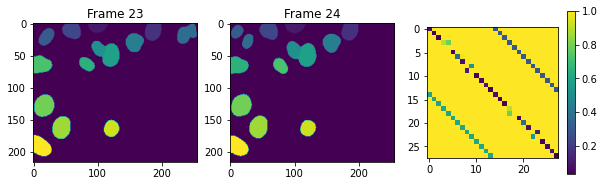

In [19]:
fig,ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(y_pred[t,...,0])
ax[0].set_title('Frame {}'.format(t))
ax[1].imshow(y_pred[t+1,...,0])
ax[1].set_title('Frame {}'.format(t+1))
cax = ax[2].imshow(cost_matrix)
fig.colorbar(cax, ax=ax[2], shrink=0.3)

### Perform linear assignment

In [20]:
from scipy.optimize import linear_sum_assignment

In [21]:
row_ind, col_ind = linear_sum_assignment(cost_matrix)

Let's map these results into an array so that we can visualize the results.

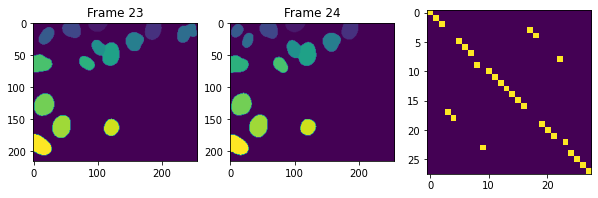

In [22]:
mapping = np.zeros((np.max(row_ind)+1, np.max(col_ind)+1))
for r, c in zip(row_ind, col_ind):
    mapping[r, c] = 1

i = 23
fig,ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(y_pred[i,...,0])
ax[0].set_title('Frame {}'.format(i))
ax[1].imshow(y_pred[i+1,...,0])
ax[1].set_title('Frame {}'.format(i+1))
ax[2].imshow(mapping)

In [ ]:
row_ind, col_ind

## Deep learning for cell tracking

While the IoU value for each pair of cells is a useful initial probability of two cells being the same between frames, it is ultimately an imperfect metric. Instead we can train a deep learning model to predict the probability of two cells being the same. The model can use information about the cell and its neighborhood in order to produce an accurate prediction. In the `deepcell_tracking` package, we have introduced the `CellTracker` which handles creating the cost matrix, performing linear assignment, and managing the cell lineage data structure to keep track of the trajectory of cells beween frames. 

### Initalize CellTracking application

Create an instance of `deepcell.applications.CellTracking`. You can learn more about how to train this model in [Training and Tracking with GNNs](https://github.com/vanvalenlab/deepcell-tf/blob/master/notebooks/training/tracking/Training%20and%20Tracking%20with%20GNNs.ipynb)

In [23]:
from deepcell.applications import CellTracking

tracker = CellTracking()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 80217fdd8477f0cb827fe72e8ace6542 so we will re-download the data.
819200/818181 [==============================] - 1s 1us/step
A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 2a4d08eb610999563f6a8f06692f8783 so we will re-download the data.
647168/645484 [==============================] - 0s 1us/step


### Track the cells

In [24]:
tracked_data = tracker.track(np.copy(x), y_pred)
X = tracked_data['X']  # raw X data
y = tracked_data['y_tracked']  # tracked y data

### Visualize tracking results

In [26]:
from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video

# Raw
HTML(get_js_video(np.expand_dims(y, axis=0),
                  batch=0))

Now that we've finished using `CellTracker.track_cells`, not only do the annotations preserve label across frames, but the lineage information has been saved in `CellTracker.tracks`.